# Exploring the Datasets

### Summary of Findings

More cleanup may be necessary on the Third Party Sign Inventory by Ward dataset.  There are a large number of unique sign sizes that were created by different people working on the 44 different source files.  Perhaps grouping them into a small/medium/large category or determining the total sign area (LxW) in a common unit of measure will be helpful.  The X and Y coordinate values do not correspond to the latitude and longitude numbers, so some form of conversion will be necessary to plot the signs on the same map as the traffic incidents dataset.  ***UPDATE JUL 27/19 - the sign data uses MTM Zone 10 coordinates!!!***  A review the outliers in these X and Y coordinate fields as well to determine a possible solution.  The sign owner information needs to be cleaned as well.  There may be a way to programmatically correct these outlying entry errors using geopandas based on the tutorial being used.  More info is required though.

The Police KSI data appears to be fairly clean.  Further review of this dataset is required to determine which columns are necessary for upcoming analysis.

The modeling methodology is still in the planning stages.  A handy tutorial from the University of Helsinki is proving to be informative: https://automating-gis-processes.github.io/CSC18/lessons/L1/Intro-Python-GIS.html

Until the review of the tutorial is complete, I won't know what I will be capable of using for any geospatial analysis.  I'm hoping to be able to determine number of signs near clusters of traffic accidents plus the details of the signs and accidents themselves in order to produce some relevent information.

### Third Party Sign Inventory by Ward

From the metadata file found as part of the package downloaded from https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/business/#9b6f952e-52d7-1fc4-51f6-4ad6bc913218:

|Column|Description|Format|
|------|-----------|------|
|Sign Account|A Tracking number for the sign structure for the purposes of the Third Party Sign Tax| |
|Street Number|Street number in the street address of the property where the sign is located|Alphanumeric|
|Street Name|Street name in the street address of the property where the sign is located| |
|Size (L x W)|The Length and Height dimension of the sign face|In feet|
|Location Description (If no address)|Description of the property where the sign is located if an exact address is not currently available|Free form text|
|X Coordinate|Geodetic coordinate of the sign structure| |
|Y Coordinate|Geodetic coordinate of the sign structure| |
|Sign Type|The Type of sign or sign structure|E.G. "GROUND" OR "ROOF"|
|Sign Technology|The Technology used to display the sign copy|E.G. "STATIC" OR "TRIVISION"|
|Sign Face Direction|The direction that the sign copy is facing|E.G. "N. S, E, W"|
|Illumination|The style of lighting on the sign or sign structure|E.G. "UP" OR "BACKLIT"|
|Sign Owner|The owner of the sign or the company in control of the sign copy| |
|Sign Owner Identifier|A unique identifier used by the Sign Owner|Alphanumeric|
|Context Picture Hyperlink|A web link to an aerial photo of the sign and surrounding area|Hyperlink|


!conda install -c anaconda xlrd --yes

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import xlrd

# Set the file path
fp = "../data/SignData"

df_signs = None

# Loop through the excel source files and build the consolidated dataframe
# Do this backwards as most of the files do not share the same column names as file 1
for i in range(44,0, -1):
    
    # file 22 starts on a different row on the spreadsheet
    if i!=22:
        df_temp = pd.read_excel(fp + "/WARD " + str(i) + ".xls", skiprows=4)
    else:
        df_temp = pd.read_excel(fp + "/WARD " + str(i) + ".xls", skiprows=5)
        
    df_temp['Ward_ID'] = i
    
    # Check for the presense of a "NOTES" column, then remove it
    if "NOTES" in df_temp.columns:
        df_temp.drop(columns="NOTES", inplace=True)    
    
    # for the first file, get the list of columns to copy to the other files as they are imported    
    if i==44:
        df_signs = df_temp.copy()
        col_names = df_signs.columns
        # Some debugging here...
        print(col_names)
        print(str(len(df_temp.columns)) + " : " + str(i))
    else:
        # Some debugging here...
        print(str(i) + " : " + str(df_temp.columns.difference(col_names)))
        df_temp.columns = col_names
        df_signs = df_signs.append(df_temp, ignore_index=True, sort=False)
        print(str(len(df_temp.columns)) + " : " + str(i) + " : " + str(df_temp.shape))

Index(['Sign Account', 'Street Number', 'Street Name', 'Size (LxW)',
       'Location Description (if no address)', 'X Coordinate', 'Y Coordinate',
       'Sign Type', 'Sign Technology (description)', 'Sign Face Direction',
       'Illumination', 'Sign Co. Name', 'Sign Co. Sign Identifier',
       'Context Picture Hyperlink', 'Ward_ID'],
      dtype='object')
15 : 44
43 : Index(['SIZE (LXW)'], dtype='object')
15 : 43 : (28, 15)
42 : Index(['SIZE (LXW)'], dtype='object')
15 : 42 : (37, 15)
41 : Index(['SIZE (LXW)'], dtype='object')
15 : 41 : (90, 15)
40 : Index(['SIZE (LXW)'], dtype='object')
15 : 40 : (25, 15)
39 : Index([], dtype='object')
15 : 39 : (7, 15)
38 : Index([], dtype='object')
15 : 38 : (34, 15)
37 : Index(['SIZE (LXW)'], dtype='object')
15 : 37 : (128, 15)
36 : Index(['SIZE (LXW)'], dtype='object')
15 : 36 : (64, 15)
35 : Index(['SIZE (LXW)'], dtype='object')
15 : 35 : (133, 15)
34 : Index(['SIZE (LXW)'], dtype='object')
15 : 34 : (64, 15)
33 : Index([], dtype='object')
15

In [2]:
# Replace the column names with the list of names provided in the metadata file
meta_cols = ['Sign Account', 'Street Number', 'Street Name', 'Size (LxW)',
       'Location Description (if no address)', 'X Coordinate', 'Y Coordinate',
       'Sign Type', 'Sign Technology', 'Sign Face Direction',
       'Illumination', 'Sign Owner', 'Sign Owner Identifier',
       'Context Picture Hyperlink', 'Ward_ID']

df_signs.columns = meta_cols

In [3]:
df_signs.head()

,Sign Account,Street Number,Street Name,Size (LxW),Location Description (if no address),X Coordinate,Y Coordinate,Sign Type,Sign Technology,Sign Face Direction,Illumination,Sign Owner,Sign Owner Identifier,Context Picture Hyperlink,Ward_ID
0,44-001,4566-4568,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330183,4.84801e+06,Ground,Static,W,Down,Pattison,5364A,http://maps.live.com/default.aspx?v=2&FORM=LML...,44
1,44-001,4566-4568,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330184,4.848e+06,Ground,Static,E,Down,Pattison,5364B,http://maps.live.com/default.aspx?v=2&FORM=LML...,44
2,44-002,4528,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330056,4.84784e+06,Roof,Static,NE,Up,CBS,1633,http://maps.live.com/default.aspx?v=2&FORM=LML...,44
3,44-002,4528,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330060,4.84784e+06,Roof,Static,NE,Up,CBS,1634,http://maps.live.com/default.aspx?v=2&FORM=LML...,44
4,44-002,4528,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330061,4.84784e+06,Roof,Static,SW,Up,CBS,1631,http://maps.live.com/default.aspx?v=2&FORM=LML...,44


In [4]:
df_signs.tail()

,Sign Account,Street Number,Street Name,Size (LxW),Location Description (if no address),X Coordinate,Y Coordinate,Sign Type,Sign Technology,Sign Face Direction,Illumination,Sign Owner,Sign Owner Identifier,Context Picture Hyperlink,Ward_ID
69518,01-033,2001,ALBION RD,10' x 20',East of 427 and South of Steinway Cres,284584,484054,Ground,Static,W,Up,Pattison,6150B,http://www.bing.com/maps/default.aspx?v=2&cp=r...,1
69519,01-036,1058-1066,ALBION RD,10' x 20',NaN,299560,4.84394e+06,Roof,Trivision,E,Up,CBS,NaN,http://www.bing.com/maps/?v=2&cp=r8pnsz8c2mx2&...,1
69520,01-036,1058-1066,ALBION RD,10' x 20',NaN,299560,4.84394e+06,Roof,Trivision,W,Up,CBS,NaN,http://www.bing.com/maps/?v=2&cp=r8pnsz8c2mx2&...,1
69521,01-037,40,WESTMORE DR,10' x 20',NaN,296315,4.84431e+06,Ground,Static,N,Up,Pattison,5565A,http://www.bing.com/maps/?v=2&cp=r8q3n48bzmfz&...,1
69522,01-037,40,WESTMORE DR,10' x 20',NaN,296315,4.84431e+06,Ground,Static,S,Up,Pattison,5565B,http://www.bing.com/maps/?v=2&cp=r8q3n48bzmfz&...,1


In [5]:
# Look at the shape of the dataframe
df_signs.shape

(69523, 15)

In [6]:
# Examine the fields
df_signs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69523 entries, 0 to 69522
Data columns (total 15 columns):
Sign Account                            4273 non-null object
Street Number                           4270 non-null object
Street Name                             4271 non-null object
Size (LxW)                              3999 non-null object
Location Description (if no address)    1610 non-null object
X Coordinate                            4232 non-null object
Y Coordinate                            4232 non-null object
Sign Type                               4272 non-null object
Sign Technology                         4266 non-null object
Sign Face Direction                     4140 non-null object
Illumination                            4227 non-null object
Sign Owner                              4271 non-null object
Sign Owner Identifier                   3465 non-null object
Context Picture Hyperlink               4078 non-null object
Ward_ID                              

In [7]:
# There seems to be a lot of empty cells.  Confirm this.
df_signs.isnull().sum(axis=0)

Sign Account                            65250
Street Number                           65253
Street Name                             65252
Size (LxW)                              65524
Location Description (if no address)    67913
X Coordinate                            65291
Y Coordinate                            65291
Sign Type                               65251
Sign Technology                         65257
Sign Face Direction                     65383
Illumination                            65296
Sign Owner                              65252
Sign Owner Identifier                   66058
Context Picture Hyperlink               65445
Ward_ID                                     0
dtype: int64

In [8]:
# How many rows are empty?  Let's view these rows
df_signs[df_signs.isnull().sum(axis=1)>7]

,Sign Account,Street Number,Street Name,Size (LxW),Location Description (if no address),X Coordinate,Y Coordinate,Sign Type,Sign Technology,Sign Face Direction,Illumination,Sign Owner,Sign Owner Identifier,Context Picture Hyperlink,Ward_ID
2715,15-107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
3264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [9]:
# Most appear to be from Ward 11.  How many rows are not in Ward 11?
df_signs[(df_signs.isnull().sum(axis=1)>7) & (df_signs['Ward_ID']!=11)]

,Sign Account,Street Number,Street Name,Size (LxW),Location Description (if no address),X Coordinate,Y Coordinate,Sign Type,Sign Technology,Sign Face Direction,Illumination,Sign Owner,Sign Owner Identifier,Context Picture Hyperlink,Ward_ID
2715,15-107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15


In [10]:
# Drop these rows as they do not contribute anything useful
df_signs = df_signs[df_signs.isnull().sum(axis=1)<8]

In [11]:
# How many empty cells remain?
df_signs.isnull().sum(axis=0)

Sign Account                               0
Street Number                              2
Street Name                                1
Size (LxW)                               273
Location Description (if no address)    2663
X Coordinate                              40
Y Coordinate                              40
Sign Type                                  0
Sign Technology                            6
Sign Face Direction                      132
Illumination                              45
Sign Owner                                 1
Sign Owner Identifier                    807
Context Picture Hyperlink                194
Ward_ID                                    0
dtype: int64

In [12]:
# The X and Y coordinates will be most useful in the Geo-spatial analysis.  
# Check the rows where X and Y are empty
df_signs[df_signs['X Coordinate'].isnull()]

,Sign Account,Street Number,Street Name,Size (LxW),Location Description (if no address),X Coordinate,Y Coordinate,Sign Type,Sign Technology,Sign Face Direction,Illumination,Sign Owner,Sign Owner Identifier,Context Picture Hyperlink,Ward_ID
629,34-035,0,GREEN BELT DR,10' x 20',"South of Lawrence Ave. E., West of DVP & CNR, ...",NaN,NaN,Ground,Static,N,Up,CBS,NaN,NaN,34
630,34-035,0,GREEN BELT DR,10' x 20',"South of Lawrence Ave. E., West of DVP & CNR, ...",NaN,NaN,Ground,Static,S,Up,CBS,NaN,NaN,34
1003,30-125,9,DAVIES AVE,68.74,NaN,NaN,NaN,Wall,Static,E,Up,Strategic Media,NaN,NaN,30
1005,30-129,79,EAST DON ROADWAY,96.62 m2,NaN,NaN,NaN,Ground,Static,NaN,Up,Streetlife Media Inc.,NaN,NaN,30
1432,27-136,19,YORKVILLE AVE,18m2,NaN,NaN,NaN,Wall,Static,E,NaN,Megaposter,NaN,NaN,27
1660,23-051,89,FINCH AVE W,NaN,S/W corner of Talbot Rd and Finch Ave W,NaN,NaN,Roof,Trivision,E,Backlit,PYRAMIDS ENGINEERING INC.,NaN,NaN,23
1661,23-051,89,FINCH AVE W,NaN,S/W corner of Talbot Rd and Finch Ave W,NaN,NaN,Roof,Trivision,W,Backlit,PYRAMIDS ENGINEERING INC.,NaN,NaN,23
1662,23-052,4702-4704,YONGE ST,NaN,NaN,NaN,NaN,Roof,Trivision,E,Backlit,CBS,NaN,NaN,23
1663,23-052,4702-4704,YONGE ST,NaN,NaN,NaN,NaN,Roof,Trivision,W,Backlit,CBS,NaN,NaN,23
1664,23-053,5050,YONGE ST,NaN,NaN,NaN,NaN,Ground,Static,E,Up,ATEC SIGNS,NaN,NaN,23


In [13]:
# For now, any NaN in the X and Y Coordinate columns will be changed to zero
df_signs['X Coordinate'][df_signs['X Coordinate'].isnull()] = 0
df_signs['Y Coordinate'][df_signs['Y Coordinate'].isnull()] = 0

In [14]:
# Check the NaN under the street number
df_signs[df_signs['Street Number'].isnull()]

,Sign Account,Street Number,Street Name,Size (LxW),Location Description (if no address),X Coordinate,Y Coordinate,Sign Type,Sign Technology,Sign Face Direction,Illumination,Sign Owner,Sign Owner Identifier,Context Picture Hyperlink,Ward_ID
2925,13-063,NaN,DUNDAS ST W,10' x 40',NaN,305902,483942.20,Ground,Static,W,Up,Pattison,NaN,http://www.bing.com/maps/?v=2&cp=r89v308c8jf9&...,13
2926,13-063,NaN,DUNDAS ST W,10' x 40',NaN,305902,483942.20,Ground,Static,E,Up,Pattison,NaN,http://www.bing.com/maps/?v=2&cp=r89v308c8jf9&...,13


In [15]:
# According to the hyperlink, the address is 3441 Dundas St W
df_signs['Street Number'][df_signs['Street Number'].isnull()] = 3441

In [16]:
# Check the street name NaN
df_signs[df_signs['Street Name'].isnull()]

,Sign Account,Street Number,Street Name,Size (LxW),Location Description (if no address),X Coordinate,Y Coordinate,Sign Type,Sign Technology,Sign Face Direction,Illumination,Sign Owner,Sign Owner Identifier,Context Picture Hyperlink,Ward_ID
3030,12-054,1515,NaN,NaN,N/E corner of Keele St and Lavender Rd,0,0,Pedestal,Static,NaN,No Illumination,Pattison,NaN,NaN,12


In [17]:
# According to the hyperlink and street number, this is most likely on Keele St
df_signs['Street Name'][df_signs['Street Name'].isnull()] = 'KEELE ST'

In [18]:
# Change all NaN under the remaining columns to 'unknown'
df_signs['Size (LxW)'][df_signs['Size (LxW)'].isnull()] = 'unknown'
df_signs['Location Description (if no address)'][df_signs['Location Description (if no address)'].isnull()] = 'unknown'
df_signs['Sign Technology'][df_signs['Sign Technology'].isnull()] = 'unknown'
df_signs['Sign Face Direction'][df_signs['Sign Face Direction'].isnull()] = 'unknown'
df_signs['Illumination'][df_signs['Illumination'].isnull()] = 'unknown'
df_signs['Sign Owner'][df_signs['Sign Owner'].isnull()] = 'unknown'
df_signs['Sign Owner Identifier'][df_signs['Sign Owner Identifier'].isnull()] = 'unknown'
df_signs['Context Picture Hyperlink'][df_signs['Context Picture Hyperlink'].isnull()] = 'unknown'

In [19]:
# Verify no nulls exist
df_signs.isnull().sum(axis=0)

Sign Account                            0
Street Number                           0
Street Name                             0
Size (LxW)                              0
Location Description (if no address)    0
X Coordinate                            0
Y Coordinate                            0
Sign Type                               0
Sign Technology                         0
Sign Face Direction                     0
Illumination                            0
Sign Owner                              0
Sign Owner Identifier                   0
Context Picture Hyperlink               0
Ward_ID                                 0
dtype: int64

In [20]:
# Examine the Size (LxW) field
print(df_signs['Size (LxW)'].value_counts())

10' x 20'                                                                                                                                       2476
10 x 20                                                                                                                                          348
12' x 16'                                                                                                                                        336
unknown                                                                                                                                          273
10' x 40'                                                                                                                                        128
10 X 20                                                                                                                                           58
12 x 16                                                                                                   

In [21]:
# a bit if a mess... first get rid of the ' symbol as it is presumed to be feet from the metadata file
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace("'","")
#df_signs['Size (LxW)'].value_counts()

In [22]:
# Next replace capital X with lower case x
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace("X","x")
#df_signs['Size (LxW)'].value_counts()

In [23]:
# Next remove any "= xxx" patterns
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace("=.*","", regex=True)
#df_signs['Size (LxW)'].value_counts()

In [24]:
# Next replace m2 with m
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace("m2",u'm\u00B2')
# ensure there is at least one space surrounding each m2 and in front of each m
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace(u'm\u00B2',u' m\u00B2 ')
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace(u'm',u' m')
#df_signs['Size (LxW)'].value_counts()

In [25]:
# Next ensure there is at least a single space around each 'x'
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace("x"," x ")
#df_signs['Size (LxW)'].value_counts()

In [26]:
# Next replace multiple spaces with a single space
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace("\s{2,}"," ", regex=True)
#df_signs['Size (LxW)'].value_counts()

In [27]:
# Strip any leading or trailing whitespace
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.strip()
#df_signs['Size (LxW)'].value_counts()

In [28]:
# Next replace pedestal with Pedestal
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace("pedestal","Pedestal")
#df_signs['Size (LxW)'].value_counts()

In [29]:
# Next remove " structure" and check the counts
df_signs['Size (LxW)'] = df_signs['Size (LxW)'].str.replace(" structure","")
df_signs['Size (LxW)'].value_counts()

10 x 20              2932
12 x 16               406
unknown               273
10 x 40               143
10 x 23                47
10 x 35                37
10 x 25                32
14 x 48                27
5.6 m²                 26
Pedestal               23
2.25 m² x 4 sides      19
8.92 m²                 8
10 x 50                 7
20 x 60                 6
20 x 20                 6
10 x 30                 6
15 x 40                 5
15 x 25                 4
25 x 25                 4
40 x 20                 3
2.25 m²                 3
2.25 m² x 2             3
31.39 m²                3
25 x 50                 3
19 x 25                 3
25 m²                   3
10 x 48                 2
60 x 37                 2
50 x 35                 2
20 x 50                 2
                     ... 
30.9 m²                 1
18.58 m²                1
28.52 m²                1
83.61 m²                1
Appro x . 100 m²        1
33.75 x 75              1
16.72 m²                1
273.13 m²   

In [30]:
# Examine the Sign Technology field
print(df_signs['Sign Technology'].value_counts())

Static                                                                                                    3734
static                                                                                                     177
Trivision                                                                                                   88
Tri-Vision                                                                                                  62
Tri Vision                                                                                                  19
Static (Faces:2)                                                                                            15
Single Face, Static                                                                                         14
Digital LED                                                                                                 12
Digital                                                                                                     11
V

In [31]:
# Cleanup - first convert all to Upper Case
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.upper()
#df_signs['Sign Technology'].value_counts()

In [32]:
# Fix Trivision spelling issues
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("TRI-VISION","TRIVISION")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("TRI VISION","TRIVISION")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("TRIVISON","TRIVISION")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("TIRIVISON","TRIVISION")
#df_signs['Sign Technology'].value_counts()

In [33]:
# Fix issues with the FACES labels
# Update - regardless of the number of faces, it is still a static sign.  Remove the faces info.
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("SINGLE FACE, ","")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("FACE:","FACES:")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("("," (")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("FACES: ","FACES:")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace(" FACES:","FACES:")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("\s{2,}"," ", regex=True)
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.strip()

df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("\s\(FACES:[245]\)","", regex=True)
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.strip()

#df_signs['Sign Technology'].value_counts()

In [34]:
# Fix issues with the Digital LED labels
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("DIGITAL LED","LED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("DIGITAL","LED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("ELECTRONIC MOVING COPY","LED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.strip()
#df_signs['Sign Technology'].value_counts()

In [35]:
# Fix issues with the Video Display Boards
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("VIDEO DISPLAY BOARD","VDB")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("VIDEO DISPLAY","VDB")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.strip()
#df_signs['Sign Technology'].value_counts()

In [36]:
# Fix the painted mural label
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("PAINTED MURAL","MURAL")
#df_signs['Sign Technology'].value_counts()

In [37]:
# Any value identifying more then one technology, change to MIXED then view the resulting counts
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("READOGRAPH AND STATIC","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("ONE STATIC, ONE READOGRAPH","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("TRIVISION AND VDB","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("STATIC AND READOGRAPH","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("STATIC READOGRAPH","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("VDB, STATIC","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("TRIVISION AND SINGLE FACE STATIC","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("STATIC; READOGRAPH","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("STATIC, VDB","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("STATIC TRIVISION VDB","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("TRIVISION/ VDB/STATIC","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("STATIC/LED","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("TRIVISION, STATIC, LED","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("STATIC AND VDB","MIXED")
df_signs['Sign Technology'] = df_signs['Sign Technology'].str.replace("ONE STATIC, ONE VDB, ONE TRIVISION FACE","MIXED")
df_signs['Sign Technology'].value_counts()

STATIC        3995
TRIVISION      193
LED             28
MIXED           22
VDB             16
MURAL            8
UNKNOWN          6
PEDESTAL         2
READOGRAPH       1
VINYL            1
Name: Sign Technology, dtype: int64

In [38]:
# Examine the Sign Owner field
print(df_signs['Sign Owner'].value_counts())

CBS                                                1615
Pattison                                           1471
Astral Media                                        341
Astral                                              247
PATTISON                                            168
Strategic Media                                      60
ASTRAL                                               56
TITAN                                                56
Titan                                                31
Clear Channel                                        30
Tunnel Vision                                        26
Streetlife Media                                      8
Bentall Kennedy LP                                    8
Landmark Outdoor                                      7
Owner                                                 7
IMA Outdoor                                           7
Toronto Eaton Centre                                  6
Landmark Outdoor Inc.                           

In [39]:
# Cleanup - first convert all to Upper Case
df_signs['Sign Owner'] = df_signs['Sign Owner'].str.upper()
#df_signs['Sign Owner'].value_counts()

In [40]:
# Fix issues with the Pattison
df_signs['Sign Owner'] = df_signs['Sign Owner'].str.replace("PATTISON.+","PATTISON", regex=True)
#df_signs['Sign Owner'].value_counts()

In [41]:
# Fix issues with the Astral Media
df_signs['Sign Owner'] = df_signs['Sign Owner'].str.replace("ASTRAL.+","ASTRAL", regex=True)
#df_signs['Sign Owner'].value_counts()

In [42]:
# Fix issues with Landmark
df_signs['Sign Owner'] = df_signs['Sign Owner'].str.replace("LANDMARK.+","LANDMARK", regex=True)
#df_signs['Sign Owner'].value_counts()

In [43]:
# Fix issues with RCC then view the resulting counts
df_signs['Sign Owner'] = df_signs['Sign Owner'].str.replace("RCC.+","RCC", regex=True)
df_signs['Sign Owner'].value_counts()

PATTISON                                           1644
CBS                                                1615
ASTRAL                                              648
TITAN                                                87
STRATEGIC MEDIA                                      63
CLEAR CHANNEL                                        32
TUNNEL VISION                                        26
RCC                                                  15
LANDMARK                                             15
STREETLIFE MEDIA                                      8
BENTALL KENNEDY LP                                    8
OWNER                                                 7
IMA OUTDOOR                                           7
TORONTO EATON CENTRE                                  6
MEGAPOSTER                                            5
MAPLE LEAF SPORTS & ENTERTAINMENT                     4
ABCON                                                 4
STREETLIFE MEDIA INC.                           

In [44]:
df_signs.head()

,Sign Account,Street Number,Street Name,Size (LxW),Location Description (if no address),X Coordinate,Y Coordinate,Sign Type,Sign Technology,Sign Face Direction,Illumination,Sign Owner,Sign Owner Identifier,Context Picture Hyperlink,Ward_ID
0,44-001,4566-4568,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330183,4.84801e+06,Ground,STATIC,W,Down,PATTISON,5364A,http://maps.live.com/default.aspx?v=2&FORM=LML...,44
1,44-001,4566-4568,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330184,4.848e+06,Ground,STATIC,E,Down,PATTISON,5364B,http://maps.live.com/default.aspx?v=2&FORM=LML...,44
2,44-002,4528,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330056,4.84784e+06,Roof,STATIC,NE,Up,CBS,1633,http://maps.live.com/default.aspx?v=2&FORM=LML...,44
3,44-002,4528,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330060,4.84784e+06,Roof,STATIC,NE,Up,CBS,1634,http://maps.live.com/default.aspx?v=2&FORM=LML...,44
4,44-002,4528,KINGSTON RD,10 x 20,On Kingston Rd. between Military Trail & Morni...,330061,4.84784e+06,Roof,STATIC,SW,Up,CBS,1631,http://maps.live.com/default.aspx?v=2&FORM=LML...,44


In [45]:
# Check the shape of the remaining data
df_signs.shape

(4272, 15)

In [46]:
# List the types of each column
print(df_signs.dtypes)

Sign Account                            object
Street Number                           object
Street Name                             object
Size (LxW)                              object
Location Description (if no address)    object
X Coordinate                            object
Y Coordinate                            object
Sign Type                               object
Sign Technology                         object
Sign Face Direction                     object
Illumination                            object
Sign Owner                              object
Sign Owner Identifier                   object
Context Picture Hyperlink               object
Ward_ID                                  int64
dtype: object


In [47]:
# Check X Coordinates for any fields that can not be converted to floats
df_signs['X Coordinate'][pd.to_numeric(df_signs['X Coordinate'], errors='coerce').isnull()==True]

1778    X:311677.79
1779    X:311677.79
2027    X:311080.56
2028    X:311080.56
2029     X:310662.7
2030    X:310540.73
2031    X:310212.64
2032    X:310212.64
2033       X:310235
2034       X:310235
2035     X:310254.3
2036    X:310335.25
2037     X:310575.7
2038    X:310898.83
2039    X:310898.83
2040    X:311049.97
2041    X:311049.97
2042    X:312509.32
2043    X:311357.97
2044    X:311357.97
2047     X:311623.6
2048     X:311623.6
2049    X:311711.65
2050    X:311711.65
2051       X:312210
2052       X:312210
2053    X;312230.88
2054    X:312186.41
2055    X:312252.95
2056    X:312248.53
           ...     
2131    X:311351.26
2132    X:311131.02
2133    X:311131.02
2134    X:312019.91
2135    X:312019.91
2136    X:311250.84
2137    X:311250.84
2152    X:311109.97
2153     X:31161.44
2154    X:311591.46
2155    X:311351.26
2156    X:311351.26
2157    X:311131.02
2158    X:311131.02
2159    X:312019.91
2160    X:312019.91
2168    X:311710.51
2169    X:311710.51
2170    X:311044.24


In [48]:
# For the fields that contain 'X', get the subset from the 3rd character onwards 
df_signs.loc[df_signs['X Coordinate'].str.contains('X', regex=False)>0,'X Coordinate'] = df_signs.loc[df_signs['X Coordinate'].str.contains('X', regex=False)>0,'X Coordinate'].str.slice(start=2)


In [49]:
# Check X Coordinates for any more fields that can not be converted to floats
df_signs['X Coordinate'][pd.to_numeric(df_signs['X Coordinate'], errors='coerce').isnull()==True]

Series([], Name: X Coordinate, dtype: object)

In [50]:
# Convert the X Coordinate to float
df_signs['X Coordinate'] = pd.to_numeric(df_signs['X Coordinate'], errors='coerce')

In [51]:
# Check Y Coordinates for any fields that can not be converted to floats
df_signs['Y Coordinate'][pd.to_numeric(df_signs['Y Coordinate'], errors='coerce').isnull()==True]

1778     Y:4835848.57
1779     Y:4835848.57
2027     Y:4836608.96
2028     Y:4836608.96
2029     Y:4836597.11
2030     Y:4836477.54
2031     Y:4836447.57
2032     Y:4836447.57
2033     Y:4836441.47
2034     Y:4836441.47
2035     Y:4836446.48
2036      Y:4836466.7
2037     Y:4835512.29
2038     Y:4835611.59
2039     Y:4835611.59
2040      Y:4835628.4
2041      Y:4835628.4
2042     Y:4833902.61
2043     Y:4835724.14
2044     Y:4835724.14
2047     Y:4835805.29
2048     Y:4835805.29
2049     Y:4835832.22
2050     Y:4835832.22
2053     Y:4834902.94
2054     Y:4834922.27
2055      Y:4834829.3
2056     Y:4834844.44
2057     Y:4834848.57
2059     Y:4834709.74
             ...     
2132     Y:4832519.59
2133     Y:4832519.59
2134      Y:4832272.8
2135      Y:4832272.8
2136     Y;4832020.59
2137     Y;4832020.59
2153     Y:4832681.94
2154     Y:4832659.41
2155      Y:4832543.6
2156      Y:4832543.6
2157     Y:4832519.59
2158     Y:4832519.59
2159      Y:4832272.8
2160      Y:4832272.8
2168     Y

In [52]:
# For the fields that contain 'Y', get the subset from the 3rd character onwards 
df_signs.loc[df_signs['Y Coordinate'].str.contains('Y', regex=False)>0,'Y Coordinate'] = df_signs.loc[df_signs['Y Coordinate'].str.contains('Y', regex=False)>0,'Y Coordinate'].str.slice(start=2)

In [53]:
# Check Y Coordinates for any other fields that can not be converted to floats
df_signs['Y Coordinate'][pd.to_numeric(df_signs['Y Coordinate'], errors='coerce').isnull()==True]

2923     48.4206.98
68531    4847852,23
68532    4847852,23
Name: Y Coordinate, dtype: object

In [54]:
# The record with 2 decimals should read 4834206.98, and the other values with commas should have decimals instead
df_signs.loc[2923, 'Y Coordinate'] = 4834206.98
df_signs.loc[68531, 'Y Coordinate'] = 484752.23
df_signs.loc[68532, 'Y Coordinate'] = 484752.23

In [55]:
# Convert the Y Coordinate to float
df_signs['Y Coordinate'] = pd.to_numeric(df_signs['Y Coordinate'], errors='coerce')

In [56]:
# List the types of each column
print(df_signs.dtypes)

Sign Account                             object
Street Number                            object
Street Name                              object
Size (LxW)                               object
Location Description (if no address)     object
X Coordinate                            float64
Y Coordinate                            float64
Sign Type                                object
Sign Technology                          object
Sign Face Direction                      object
Illumination                             object
Sign Owner                               object
Sign Owner Identifier                    object
Context Picture Hyperlink                object
Ward_ID                                   int64
dtype: object


In [57]:
# Look at the data summary
df_signs.describe()

,X Coordinate,Y Coordinate,Ward_ID
count,4.272000e+03,4.272000e+03,4272.000000
mean,4.997065e+05,5.694070e+06,19.701077
std,6.930755e+06,1.694588e+07,11.215992
min,0.000000e+00,0.000000e+00,1.000000
25%,3.058507e+05,4.834936e+06,11.000000
50%,3.111833e+05,4.838869e+06,19.000000
75%,3.168309e+05,4.843549e+06,28.000000
max,3.212480e+08,4.844071e+08,44.000000


In [58]:
# How many X and Y Coordinates were set to 0
print('Number of X Coordinates set to 0:  ', df_signs['X Coordinate'][df_signs['X Coordinate']==0].count())
print('Number of Y Coordinates set to 0:  ', df_signs['Y Coordinate'][df_signs['Y Coordinate']==0].count())

Number of X Coordinates set to 0:   40
Number of Y Coordinates set to 0:   40


In [59]:
# Per some random spot checks using http://map.toronto.ca/maps/map.jsp?app=OpenData 
# how many X and Y Coordinates fall outside of Toronto
print('Number of X Coordinates less than 275000:  ', df_signs['X Coordinate'][df_signs['X Coordinate']<275000].count())
print('Number of X Coordinates greater than 350000:  ', df_signs['X Coordinate'][df_signs['X Coordinate']>350000].count())
print('Number of Y Coordinates less than 4800000:  ', df_signs['Y Coordinate'][df_signs['Y Coordinate']<4800000].count())
print('Number of Y Coordinates greater than 4875000:  ', df_signs['Y Coordinate'][df_signs['Y Coordinate']>4875000].count())


Number of X Coordinates less than 275000:   59
Number of X Coordinates greater than 350000:   32
Number of Y Coordinates less than 4800000:   132
Number of Y Coordinates greater than 4875000:   51


### Observations about X and Y Coordinates:

There are a number of data entry issues with these columns that could affect the results:

* Entries with no values which were set to 0 = 40
* Total X Coordinate entries that fall outside of Toronto = 59 + 32 = 91 (including entries of zero)
* Total Y Coordinate entries that fall outside of Toronto = 132 + 51 = 183 (including entries of zero)

In [60]:
# Look at the data summary of the object variables
df_signs.describe(include=['object'])

,Sign Account,Street Number,Street Name,Size (LxW),Location Description (if no address),Sign Type,Sign Technology,Sign Face Direction,Illumination,Sign Owner,Sign Owner Identifier,Context Picture Hyperlink
count,4272,4272,4272,4253,4272,4272,4272,4272,4272,4272,4272,4272
unique,2487,1543,320,208,790,4,10,14,12,68,3341,3526
top,30-074,0,EGLINTON AVE W,10 x 20,unknown,Roof,STATIC,E,Up,PATTISON,unknown,unknown
freq,8,480,161,2932,2663,2145,3995,962,3478,1644,807,194


### Initial observations relating to the object variables:

* Useful insights are likely not going to be gained from the Sign Account, Location Description, Sign Owner Identifier, and Context Picture Hyperlink fields
* Street Number and Street Name could help determine the X and Y coordinates of the signs with known data issues
* Even with the entries cleaned up, there are still a large number of unique Sizes (208 unique entries)

### Visualize the results

In [61]:
# Import the necessary libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [62]:
# apply a style
print(plt.style.available)
mpl.style.use(['ggplot'])

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


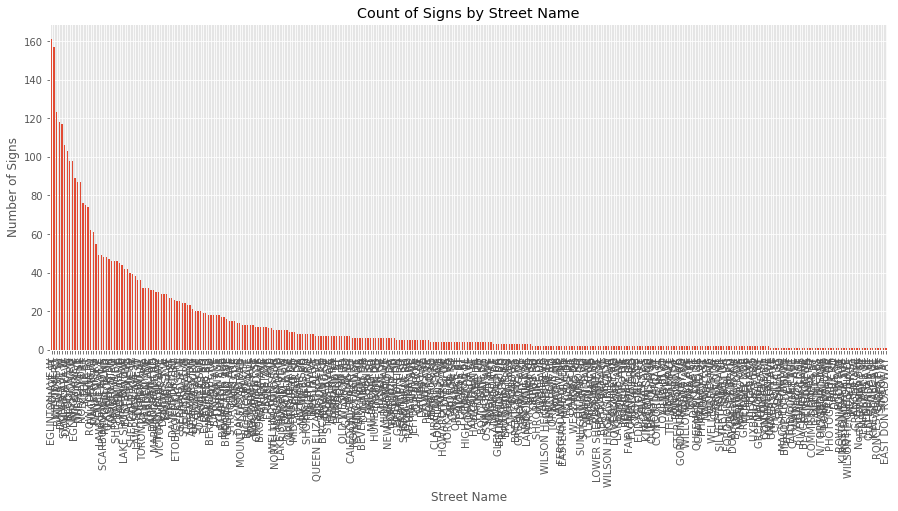

In [63]:
# Show the count of signs by the street name
df_signs['Street Name'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Signs by Street Name')
plt.ylabel('Number of Signs')
plt.xlabel('Street Name')

plt.show() # need this line to show the updates made to the figure

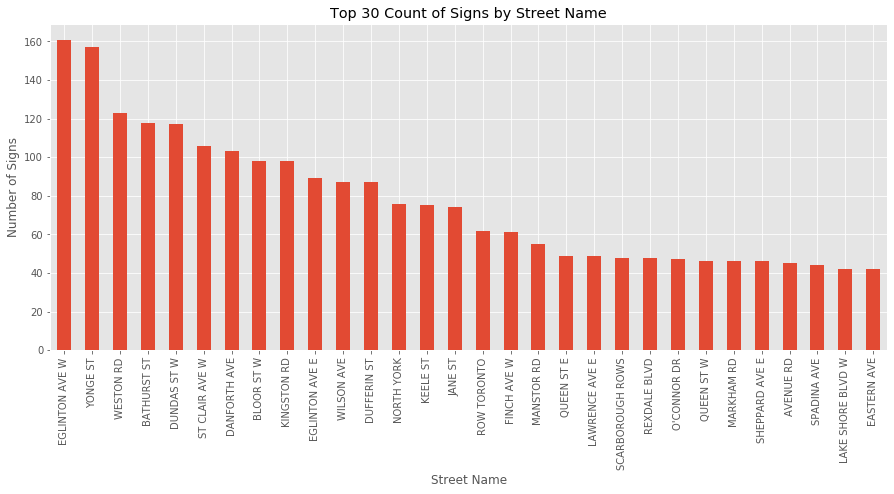

In [64]:
# Show the count of signs by their Size (LxW), but only the top 30
df_signs['Street Name'].value_counts().head(30).plot(kind='bar', figsize=(15,6))

plt.title('Top 30 Count of Signs by Street Name')
plt.ylabel('Number of Signs')
plt.xlabel('Street Name')

plt.show()

The above shows third-party signage can be found on many of the major arteries in the city.  Eglinton Avenue West and Yonge Street are the most frequent streets for these signs.

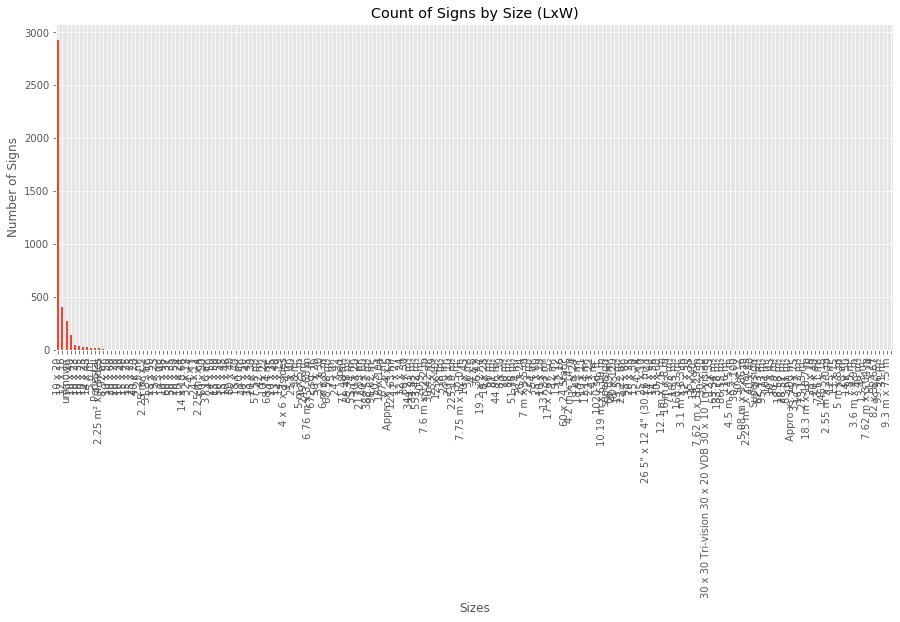

In [65]:
# Show the count of signs by their Size (LxW)
df_signs['Size (LxW)'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Signs by Size (LxW)')
plt.ylabel('Number of Signs')
plt.xlabel('Sizes')

plt.show() # need this line to show the updates made to the figure

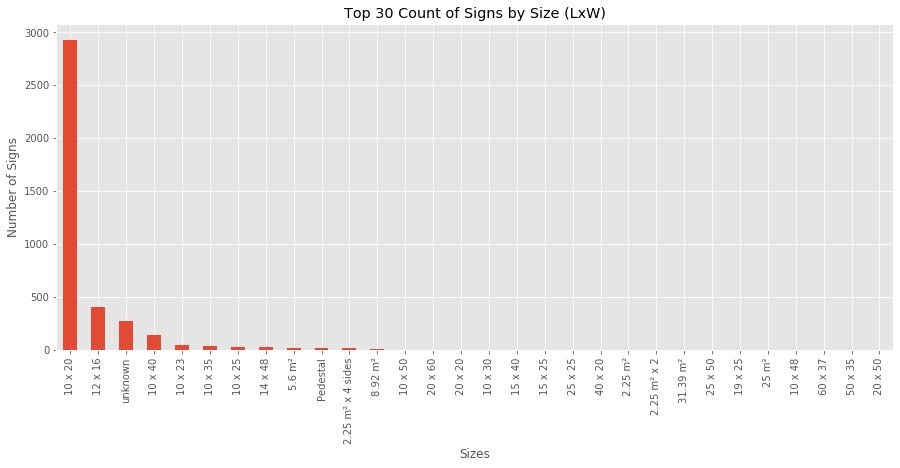

In [66]:
# Show the count of signs by their Size (LxW), but only the top 30
df_signs['Size (LxW)'].value_counts().head(30).plot(kind='bar', figsize=(15,6))

plt.title('Top 30 Count of Signs by Size (LxW)')
plt.ylabel('Number of Signs')
plt.xlabel('Sizes')

plt.show()

68% of all third-party signs found in Toronto are 10x20 feet in size.

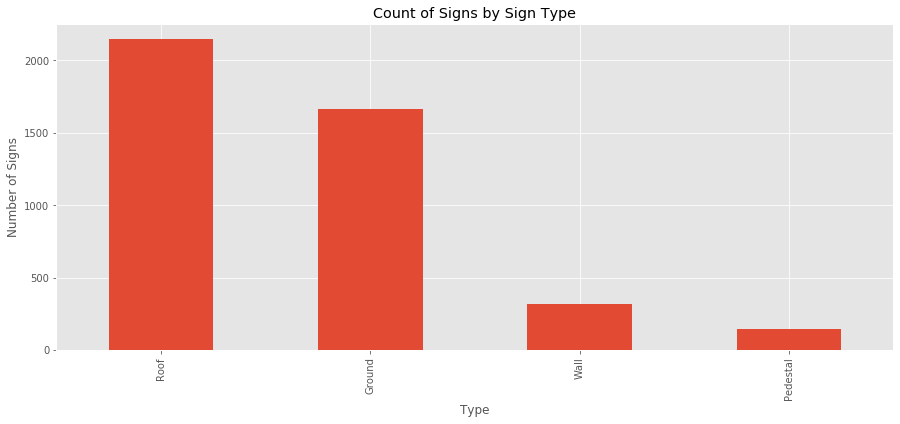

In [67]:
# Show the count of signs by their type
df_signs['Sign Type'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Signs by Sign Type')
plt.ylabel('Number of Signs')
plt.xlabel('Type')

plt.show()

The vast majority of third-party signs are mounted on building roofs (50%) and on the ground (39%).

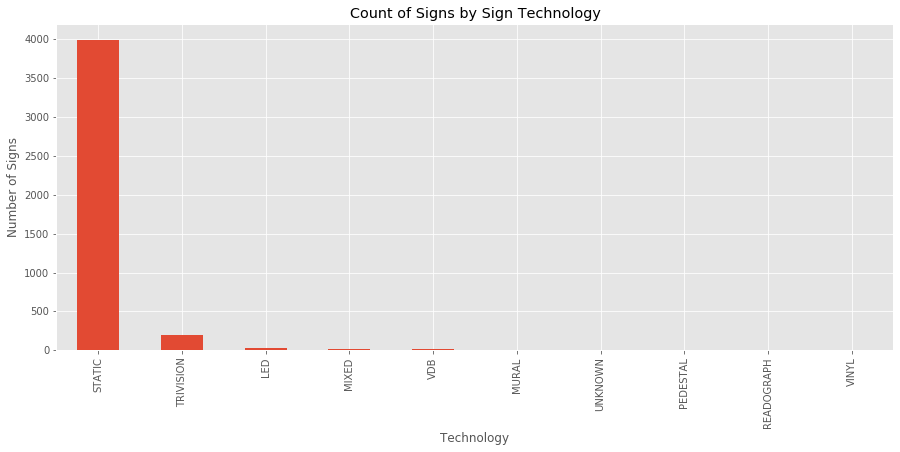

In [68]:
# Show the count of signs by their technology
df_signs['Sign Technology'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Signs by Sign Technology')
plt.ylabel('Number of Signs')
plt.xlabel('Technology')

plt.show()

Static signs make up the majority of third-party signs found in Toronto (93%).  It will be interesting to see if there is any relationship between traffic accidents and the presence of non-static signs.  Signs with flashing messages are typically in place because of their eye-catching capabilities.

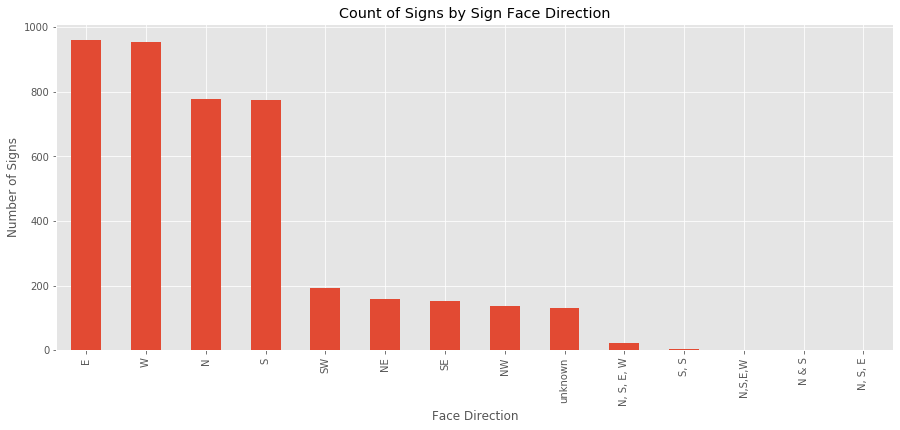

In [69]:
# Show the count of signs by their facing direction
df_signs['Sign Face Direction'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Signs by Sign Face Direction')
plt.ylabel('Number of Signs')
plt.xlabel('Face Direction')

plt.show()

The streets of Toronto are mostly set in a NS-EW grid system, so the sign facings should follow suit.  From the above, it could be noted that most of the signs are found along East-West streets.  An east-facing sign will not be noticed as much on a road where traffic flows in North-South directions.

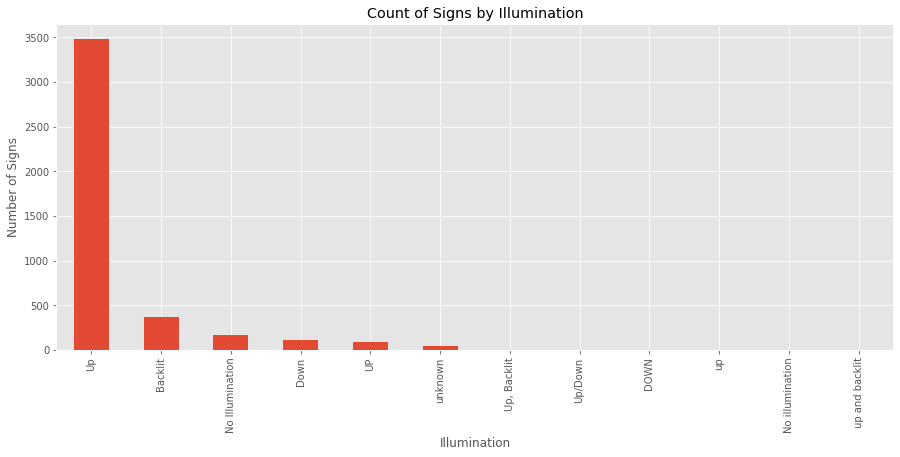

In [70]:
# Show the count of signs by their illumination
df_signs['Illumination'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Signs by Illumination')
plt.ylabel('Number of Signs')
plt.xlabel('Illumination')

plt.show()

Over 80% of the signs are illuminated upwards.  This is commonly seen on billboards where lighting is set up at the base of the sign and shown upwards towards the sign to be seen at night.

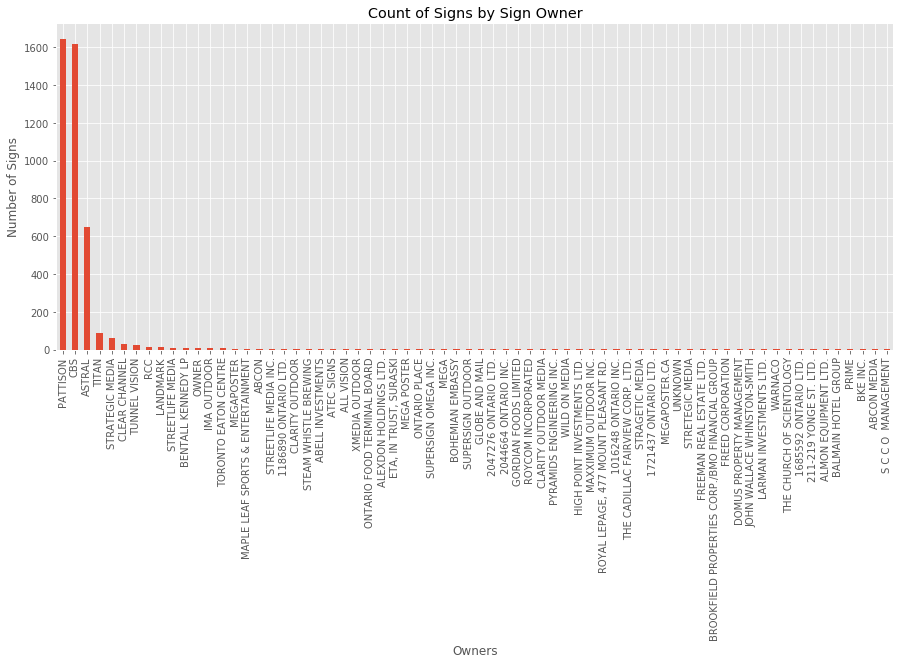

In [71]:
# Show the count of signs by Sign Owner
df_signs['Sign Owner'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Signs by Sign Owner')
plt.ylabel('Number of Signs')
plt.xlabel('Owners')

plt.show()

Pattison, CBS, and Astral are the companies most commonly selling advertising space on billboards in Toronto.  Together they own 91% of the third-party signage.

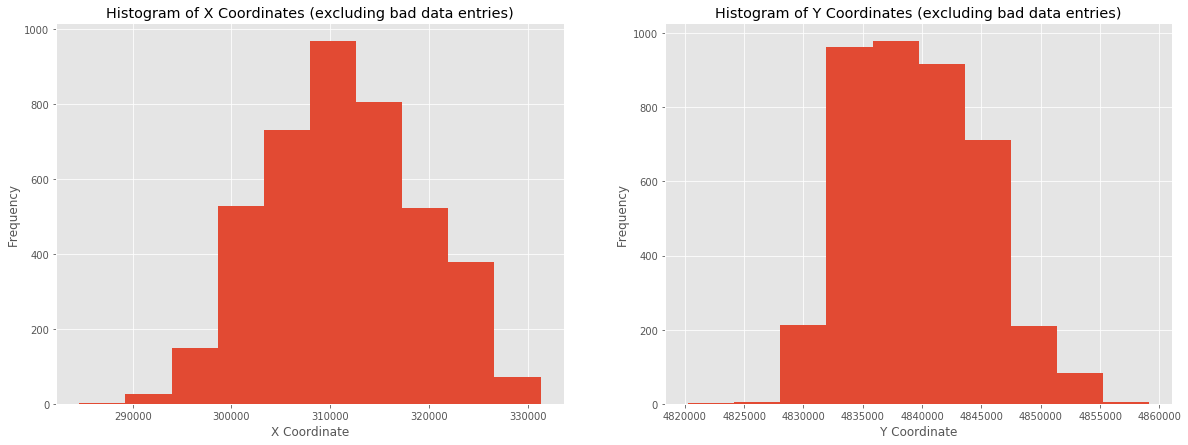

In [72]:
# histogram plots of X and Y coordinates
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Only plot the good data entries per the discussion above
df_x = df_signs[['X Coordinate']][df_signs['X Coordinate']>275000]
df_x = df_x[['X Coordinate']][df_x['X Coordinate']<350000]
df_y = df_signs[['Y Coordinate']][df_signs['Y Coordinate']>4800000]
df_y =  df_y[['Y Coordinate']][df_y['Y Coordinate']<4875000]

df_x['X Coordinate'].plot(kind='hist', figsize=(20, 7), ax=ax0)
ax0.set_title('Histogram of X Coordinates (excluding bad data entries)') 
ax0.set_xlabel('X Coordinate')

df_y['Y Coordinate'].plot(kind='hist', figsize=(20, 7), ax=ax1)
ax1.set_title('Histogram of Y Coordinates (excluding bad data entries)') 
ax1.set_xlabel('Y Coordinate')

plt.show()

The X Coordinates appear to be close to a normal distribution.  The Y Coordinates are similar, though slightly skewed right.

### Toronto Police Services - KSI Data

From the metadata file found at http://data.torontopolice.on.ca/datasets/ksi:

|Number|Field_Name|Description|Type|ObjectId|
|------|----------|-----------|----|--------|
|1|Index|Unique Identifier|Number|1|
|2|ACCNUM|Accident Number|Number|2|
|3|YEAR|Year Accident Occurred|Number|3|
|4|DATE|Date Accident Occurred|Date or Time|4|
|5|TIME|Time Accident Occurred|Text|5|
|6|HOUR|Hour Accident Occurred|Number|6|
|7|STREET1|Street Accident Occurred|Text|7|
|8|STREET2|Street Accident Occurred|Text|8|
|9|OFFSET|Distance and direction of the accident |Text|9|
|10|ROAD_CLASS|Road Classification|Text|10|
|11|District|City District|Text|11|
|12|LATITUDE|Latitude|Number|12|
|13|LONGITUDE|Longitude|Number|13|
|14|LOCCOORD|Location Coordinate|Text|14|
|15|ACCLOC|Accident Location|Text|15|
|16|TRAFFCTL|Traffic Control Type|Text|16|
|17|VISIBILITY|Environment Condition|Text|17|
|18|LIGHT|Light Condition|Text|18|
|19|RDSFCOND|Road Surface Condition|Text|19|
|20|ACCLASS|Classification of Accident|Text|20|
|21|IMPACTYPE|Initial Impact Type|Text|21|
|22|INVTYPE|Involvement Type |Text|22|
|23|INVAGE|Age of Involved Party|Text|23|
|24|INJURY|Severity of Injury|Text|24|
|25|FATAL_NO|Sequential Number |Number|25|
|26|INITDIR|Initial Direction of Travel|Text|26|
|27|VEHTYPE|Type of Vehicle|Text|27|
|28|MANOEUVER|Vehicle Manouever|Text|28|
|29|DRIVACT|Apparent Driver Action|Text|29|
|30|DRIVCOND|Driver Condition|Text|30|
|31|PEDTYPE|Pedestrian Crash Type - detail |Text|31|
|32|PEDACT|Pedestrian Action|Text|32|
|33|PEDCOND|Condition of Pedestrian|Text|33|
|34|CYCLISTYPE|Cyclist Crash Type - detail|Text|34|
|35|CYCACT|Cyclist Action|Text|35|
|36|CYCCOND|Cyclist Condition|Text|36|
|37|PEDESTRIAN|Pedestrian Involved In Collision|Text|37|
|38|CYCLIST|Cyclists Involved in Collision|Text|38|
|39|AUTOMOBILE|Driver  Involved in Collision|Text|39|
|40|MOTORCYCLE|Motorcyclist  Involved in Collision|Text|40|
|41|TRUCK|Truck Driver  Involved in Collision|Text|41|
|42|TRSN_CITY_VEH|Transit or City Vehicle  Involved in Collision|Text|42|
|43|EMERG_VEH|Emergency Vehicle  Involved in Collision|Text|43|
|44|PASSENGER|Passenger Involved in Collision|Text|44|
|45|SPEEDING|Speeding Related Collision|Text|45|
|46|AG_DRIV|Aggressive and Distracted Driving Collision|Text|46|
|47|REDLIGHT|Red Light Related Collision|Text|47|
|48|ALCOHOL|Alcohol Related Collision|Text|48|
|49|DISABILITY|Medical or Physical Disability Related Collision|Text|49|
|50|Police Division|Police Division|Text|50|
|51|City Ward|City Ward|Text|51|
|52|City Ward ID |City Ward Identificator|Number|52|
|53|Hood_ID|Neighbourhood Identificator|Number|53|
|54|Hood_Name|Neighbourhood Name|Number|54|
|55|FID|Object ID (Unique Identifier)|Unique ID|55|
|56|X|Latitude|Number|56|
|57|Y|Longitude|Number|57|


In [73]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import xlrd

# Set the file path
fp = "../data/KSIData"

df_ksi = None

# Build the dataframe
df_ksi = pd.read_csv(fp + "/ksi.csv")

In [74]:
df_ksi.head()

,X,Y,Index_,ACCNUM,YEAR,DATE,TIME,Hour,STREET1,STREET2,...,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Division,Ward_Name,Ward_ID,Hood_ID,Hood_Name,ObjectId
0,-79.454730,43.675280,80771254,7001005616,2017,2017-06-03T04:00:00.000Z,2330,23,ST CLAIR AVE W,CALEDONIA RD,...,Yes,,,,13,NaN,NaN,92,NaN,12001
1,-79.520641,43.770049,80783528,7001744141,2017,2017-09-25T04:00:00.000Z,2330,23,4673 JANE ST,,...,Yes,,,,31,NaN,NaN,24,NaN,12002
2,-79.520641,43.770049,80783529,7001744141,2017,2017-09-25T04:00:00.000Z,2330,23,4673 JANE ST,,...,Yes,,,,31,NaN,NaN,24,NaN,12003
3,-79.286601,43.751868,80790062,7003112978,2017,2017-12-01T05:00:00.000Z,2330,23,BIRCHMOUNT RD,MERRYFIELD DR,...,,,,,41,NaN,NaN,126,NaN,12004
4,-79.286601,43.751868,80790894,7003112978,2017,2017-12-01T05:00:00.000Z,2330,23,BIRCHMOUNT RD,MERRYFIELD DR,...,,,,,41,NaN,NaN,126,NaN,12005


In [75]:
df_ksi.tail()

,X,Y,Index_,ACCNUM,YEAR,DATE,TIME,Hour,STREET1,STREET2,...,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Division,Ward_Name,Ward_ID,Hood_ID,Hood_Name,ObjectId
12239,-79.607532,43.738547,80632445,6000713724,2016,2016-04-26T04:00:00.000Z,1910,19,CARRIER DR,WOODBINE DOWNS BLVD,...,Yes,,,,23,NaN,NaN,1,NaN,8996
12240,-79.343590,43.707445,6662771,1248427,2011,2011-06-26T04:00:00.000Z,1911,19,OVERLEA BLVD,THORNCLIFFE PARK DR,...,Yes,,,,53,NaN,NaN,55,NaN,8997
12241,-79.343590,43.707445,6662772,1248427,2011,2011-06-26T04:00:00.000Z,1911,19,OVERLEA BLVD,THORNCLIFFE PARK DR,...,Yes,,,,53,NaN,NaN,55,NaN,8998
12242,-79.343590,43.707445,6662773,1248427,2011,2011-06-26T04:00:00.000Z,1911,19,OVERLEA BLVD,THORNCLIFFE PARK DR,...,Yes,,,,53,NaN,NaN,55,NaN,8999
12243,-79.343590,43.707445,6662774,1248427,2011,2011-06-26T04:00:00.000Z,1911,19,OVERLEA BLVD,THORNCLIFFE PARK DR,...,Yes,,,,53,NaN,NaN,55,NaN,9000


In [76]:
# Get the shape of the dataframe
df_ksi.shape

(12244, 57)

In [77]:
# Show some basic info
df_ksi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12244 entries, 0 to 12243
Data columns (total 57 columns):
X                12244 non-null float64
Y                12244 non-null float64
Index_           12244 non-null int64
ACCNUM           12244 non-null int64
YEAR             12244 non-null int64
DATE             12244 non-null object
TIME             12244 non-null int64
Hour             12244 non-null int64
STREET1          12244 non-null object
STREET2          12244 non-null object
OFFSET           12244 non-null object
ROAD_CLASS       12244 non-null object
District         12244 non-null object
LATITUDE         12244 non-null float64
LONGITUDE        12244 non-null float64
LOCCOORD         12244 non-null object
ACCLOC           12244 non-null object
TRAFFCTL         12244 non-null object
VISIBILITY       12244 non-null object
LIGHT            12244 non-null object
RDSFCOND         12244 non-null object
ACCLASS          12244 non-null object
IMPACTYPE        12244 non-null ob

In [78]:
# Describe the data
df_ksi.describe()

,X,Y,Index_,ACCNUM,YEAR,TIME,Hour,LATITUDE,LONGITUDE,FATAL_NO,TRSN_CITY_VEH,Ward_Name,Ward_ID,Hood_ID,Hood_Name,ObjectId
count,12244.000000,12244.000000,1.224400e+04,1.224400e+04,12244.000000,12244.000000,12244.000000,12244.000000,12244.000000,12244.000000,0.0,0.0,0.0,12244.000000,0.0,12244.000000
mean,-79.396212,43.710748,3.587528e+07,2.370242e+09,2012.688909,1352.408118,13.243711,43.710748,-79.396212,1.471905,NaN,NaN,NaN,73.352499,NaN,6122.500000
std,0.103606,0.056192,3.625811e+07,3.074230e+09,3.136108,624.950019,6.257227,0.056192,0.103606,7.595429,NaN,NaN,NaN,41.372891,NaN,3534.682683
min,-79.638390,43.592047,0.000000e+00,1.284070e+05,2008.000000,0.000000,0.000000,43.592047,-79.638390,0.000000,NaN,NaN,NaN,0.000000,NaN,1.000000
25%,-79.468615,43.662445,6.176591e+06,1.180965e+06,2010.000000,920.000000,9.000000,43.662445,-79.468615,0.000000,NaN,NaN,NaN,38.000000,NaN,3061.750000
50%,-79.397290,43.702246,7.559770e+06,1.335254e+06,2012.000000,1440.000000,14.000000,43.702246,-79.397290,0.000000,NaN,NaN,NaN,77.000000,NaN,6122.500000
75%,-79.319248,43.756827,8.054227e+07,5.002033e+09,2015.000000,1838.000000,18.000000,43.756827,-79.319248,0.000000,NaN,NaN,NaN,111.000000,NaN,9183.250000
max,-79.125896,43.855445,8.109988e+07,8.008069e+09,2018.000000,2359.000000,23.000000,43.855445,-79.125896,78.000000,NaN,NaN,NaN,140.000000,NaN,12244.000000


#### Observations on the numeric data described above:

* The X and Y/LONGITUDE and LATITUDE values do not correspond with the X and Y Coordinates found in the Sign dataset.  Some conversion will be required to one of these datasets.
* This dataset covers the years 2008 to 2018
* The Hour field could be useful in determining any possible time of day relationships

In [79]:
# Describe the non-numeric data - split this up due to the large number of columns
df_ksi.iloc[:,1:20].describe(include='object')

,DATE,STREET1,STREET2,OFFSET,ROAD_CLASS,District,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT
count,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244
unique,2623,1410,2115,341,9,6,5,11,10,9,9
top,2014-08-17T04:00:00.000Z,YONGE ST,,,Major Arterial,Toronto and East York,Intersection,At Intersection,No Control,Clear,Daylight
freq,35,244,1053,10259,8343,4521,8236,5747,5921,10515,7123


In [80]:
# Describe the non-numeric data - part 2
df_ksi.iloc[:,21:40].describe(include='object')

,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST
count,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244
unique,2,10,20,21,6,6,28,17,14,11,17,16,11,23,12,11,2,2
top,Non-Fatal Injury,Pedestrian Collisions,Driver,unknown,None,,"Automobile, Station Wagon",,,,,,,,,,,
freq,10538,5002,5548,1811,4465,3423,5002,5222,6064,6060,10182,10180,10159,11703,11697,11698,7246,10903


In [81]:
# Describe the non-numeric data - part 3
df_ksi.iloc[:,41:].describe(include='object')

,MOTORCYCLE,TRUCK,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Division
count,12244,12244,12244,12244,12244,12244,12244,12244,12244,12244
unique,2,2,2,2,2,2,2,2,2,52
top,,,,,,Yes,,,,42
freq,11192,11522,12218,7750,10209,6324,11285,11757,11904,1153


#### Observations on the non-numeric data above 

* Interesting location identifiers in this dataset include ROAD_CLASS, District, LOCCOORD, ACCLOC, and TRAFFCTL.  More info is needed to determine if these fields can be used in the spatial analysis portion of this project.
* VISIBILITY and LIGHT could be factors.  Days that are not clear may need to be removed from the dataset to exclude lack of visibility as a factor in the traffic collisions.
* Vehicle type will need to be reviewed to ensure only vehicular collisions are included in the analysis.
* Incidents involving alcohol may also need to be removed to exclude this as a contributing factor in the collisions.

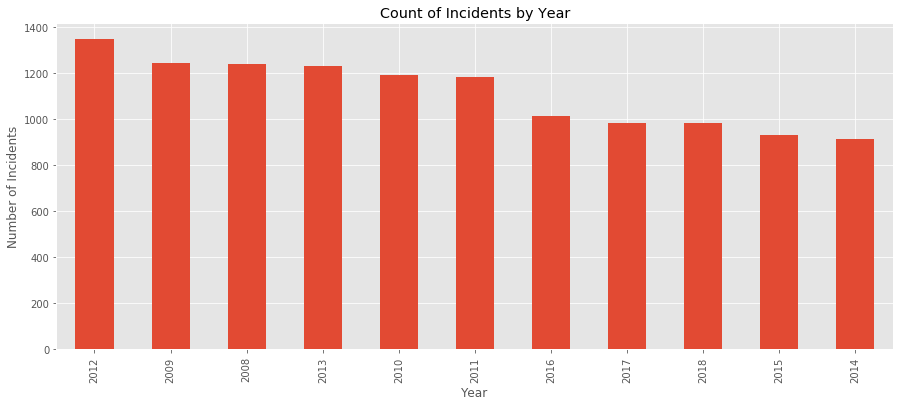

In [82]:
# Show the count of incidents by year
df_ksi['YEAR'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Year')
plt.ylabel('Number of Incidents')
plt.xlabel('Year')

plt.show()

The number of annual traffic collisions have dropped after 2012.

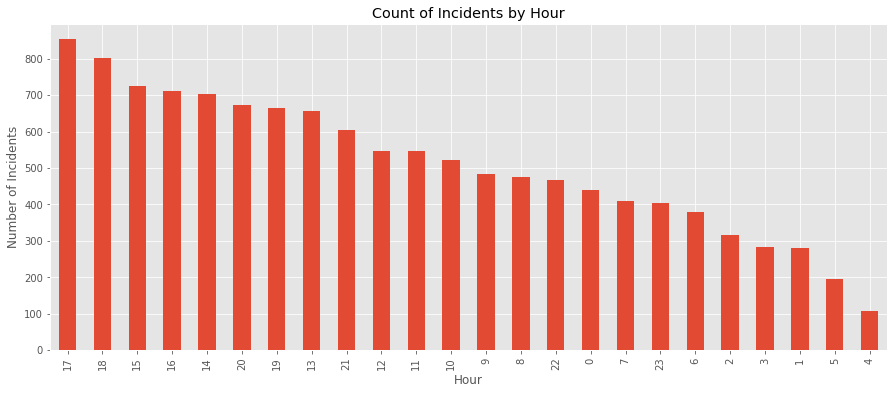

In [83]:
# Show the count of incidents by the hour they occurred
df_ksi['Hour'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Hour')
plt.ylabel('Number of Incidents')
plt.xlabel('Hour')

plt.show()

The evening rush hour period from 2:00pm to 6:00pm has the greatest number of traffic collisions.

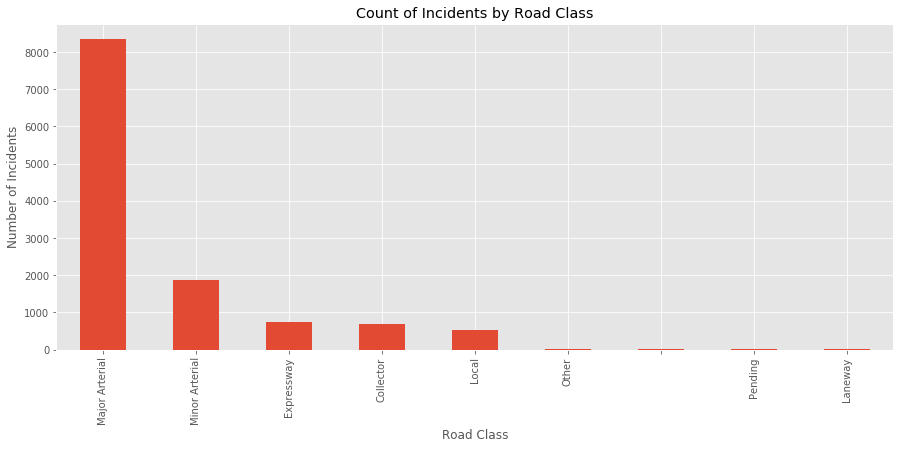

In [84]:
# Show the count of incidents by the road class
df_ksi['ROAD_CLASS'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Road Class')
plt.ylabel('Number of Incidents')
plt.xlabel('Road Class')

plt.show()

The major arteries (e.g. Yonge Street) make up the greatest number of traffic collisions (68%).

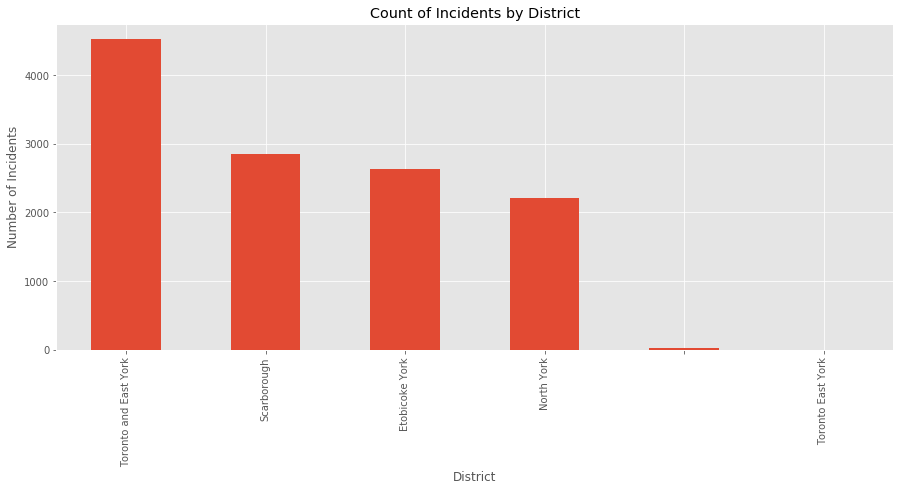

In [85]:
# Show the count of incidents by the district
df_ksi['District'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by District')
plt.ylabel('Number of Incidents')
plt.xlabel('District')

plt.show()

Traffic incidents are spread out across the entire city with the greatest proportion occuring in Toronto and East York (37%).

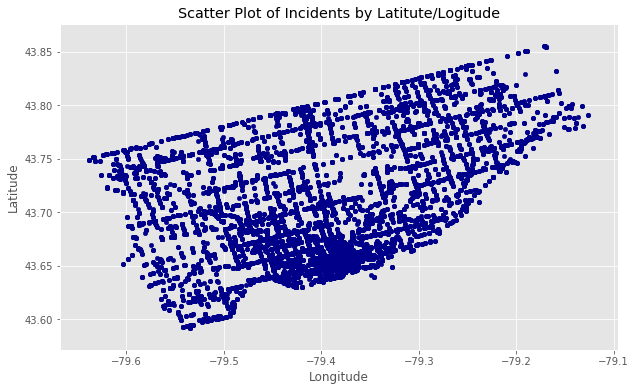

In [86]:
# Scatter plot the LAT LON coordinates for now, do this geographically later
df_ksi.plot(kind='scatter', y='LATITUDE', x='LONGITUDE', figsize=(10, 6), color='darkblue')

plt.title('Scatter Plot of Incidents by Latitute/Logitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

It's interesting to note that the resulting scatter plot of all traffic accidents produces a fairly accurate visual representation of the city.  There appears to be a high concentration of incidents around Latitude 43.65 and Longitude -79.4.

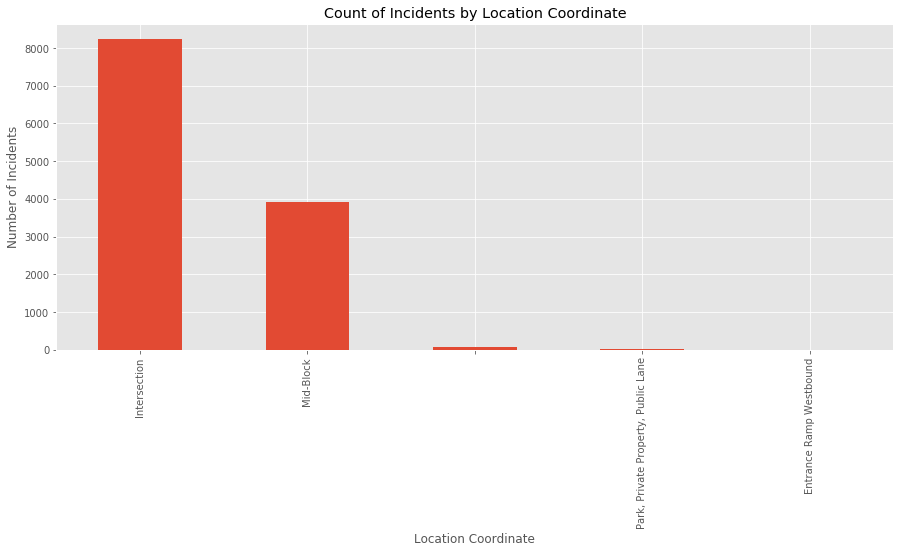

In [87]:
# Show the count of incidents by the location coordinate
df_ksi['LOCCOORD'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Location Coordinate')
plt.ylabel('Number of Incidents')
plt.xlabel('Location Coordinate')

plt.show()

Intersections have the greatest number of traffic collisions as they typically have the greatest number of distractions including traffic lights, pedestrian crossings, on-coming and crossing vehicular traffic, etc.  It may be difficult to correlate third-party signage into these incidents.  However, it may be easier to correlate incidents that happen Mid-Block.

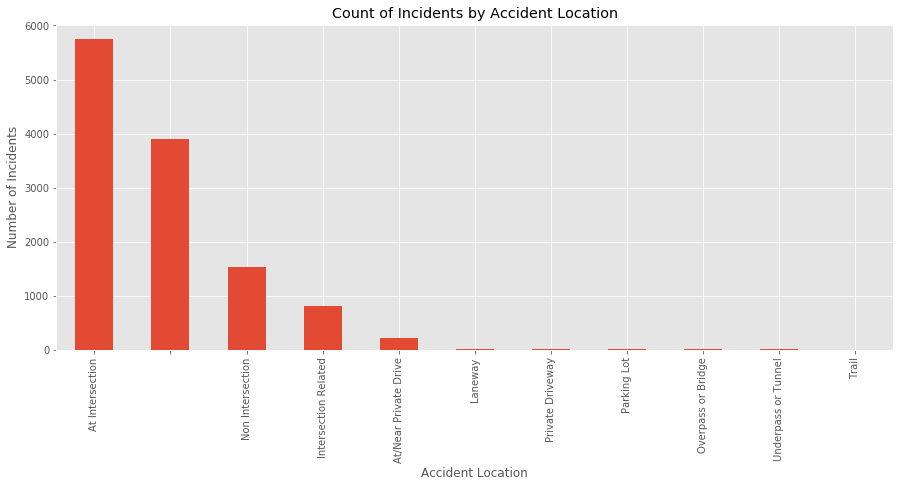

In [88]:
# Show the count of incidents by the accident location
df_ksi['ACCLOC'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Accident Location')
plt.ylabel('Number of Incidents')
plt.xlabel('Accident Location')

plt.show()

Similar to the Location Coordinate observations, the majority of the "Accident Location" incidents occur "At Intersection".  The Location Coordinate field may be better suited as a filter for the spatial models.

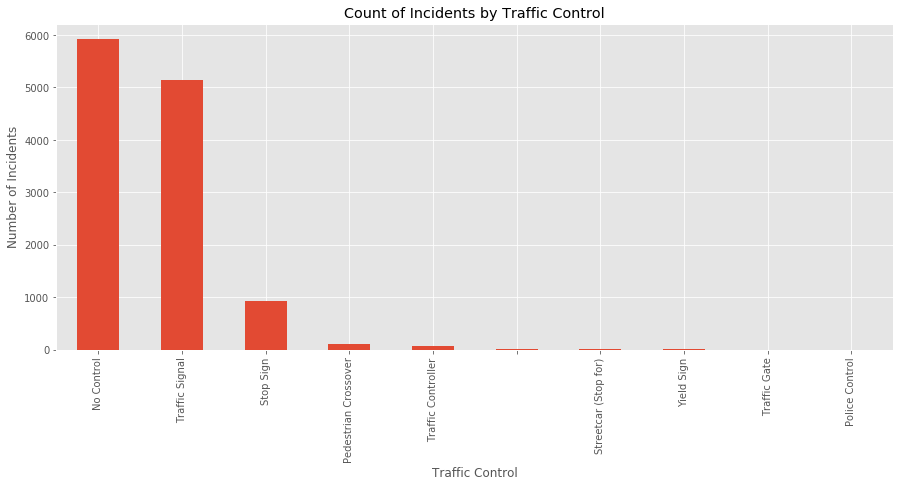

In [89]:
# Show the count of incidents by the traffic control 
df_ksi['TRAFFCTL'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Traffic Control')
plt.ylabel('Number of Incidents')
plt.xlabel('Traffic Control')

plt.show()

The above also seems to tie in with the Location Coordinate observations, but may be useful in the spatial modeling portion of the project.

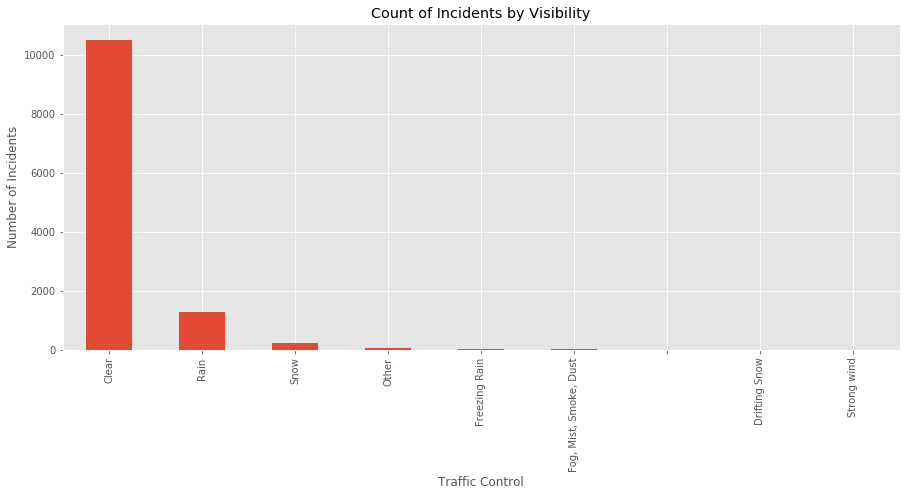

In [90]:
# Show the count of incidents by visibility 
df_ksi['VISIBILITY'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Visibility')
plt.ylabel('Number of Incidents')
plt.xlabel('Traffic Control')

plt.show()

The Clear days will be most useful in the spatial modeling.  Any way to remove these extra contributing factors to the traffic collisions will be beneficial in producing possible results.

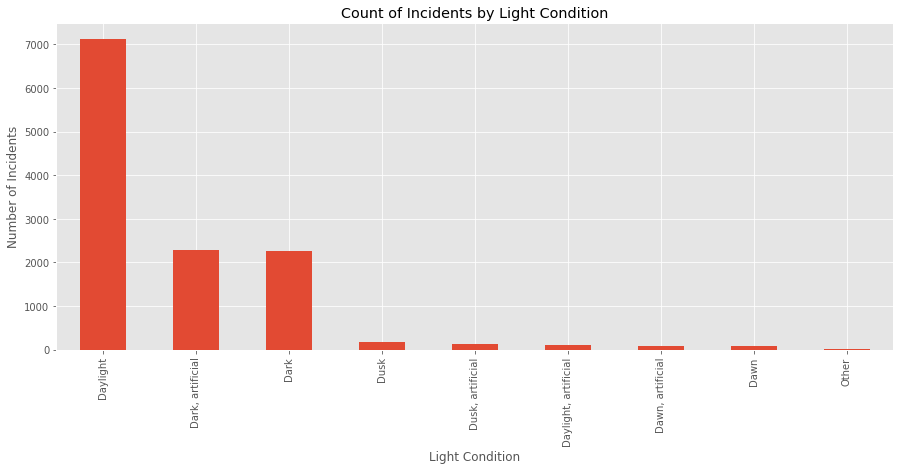

In [91]:
# Show the count of incidents by light condition 
df_ksi['LIGHT'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Light Condition')
plt.ylabel('Number of Incidents')
plt.xlabel('Light Condition')

plt.show()

There may be some benefit in using Light Condition in the models as well.  Perhaps the lighting used to help make these third-party signs visible at night is a contributing factor in the number of traffic collisions.

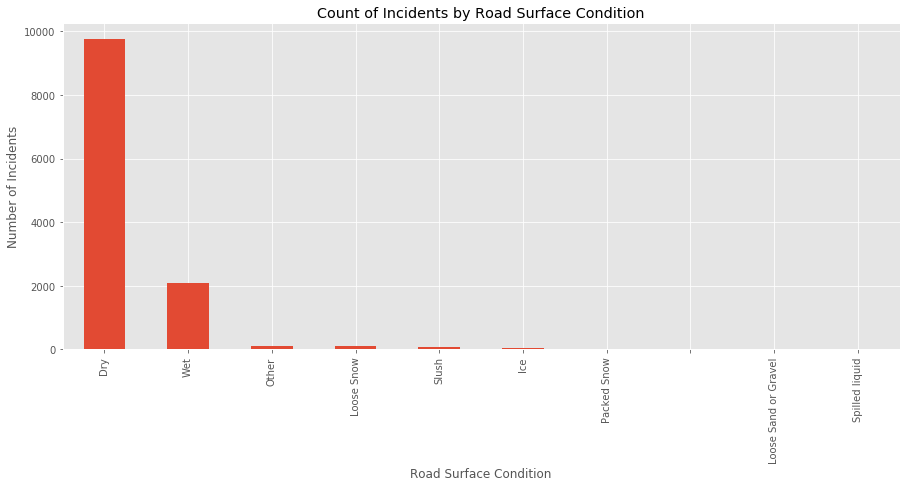

In [92]:
# Show the count of incidents by road surface condition 
df_ksi['RDSFCOND'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Road Surface Condition')
plt.ylabel('Number of Incidents')
plt.xlabel('Road Surface Condition')

plt.show()

Road Surface Condition will also be a useful field in the spatial models.  Any road conditions that are not dry should be excluded from the models.  Fortunately the majority of incidents occur in Dry conditions (80%).

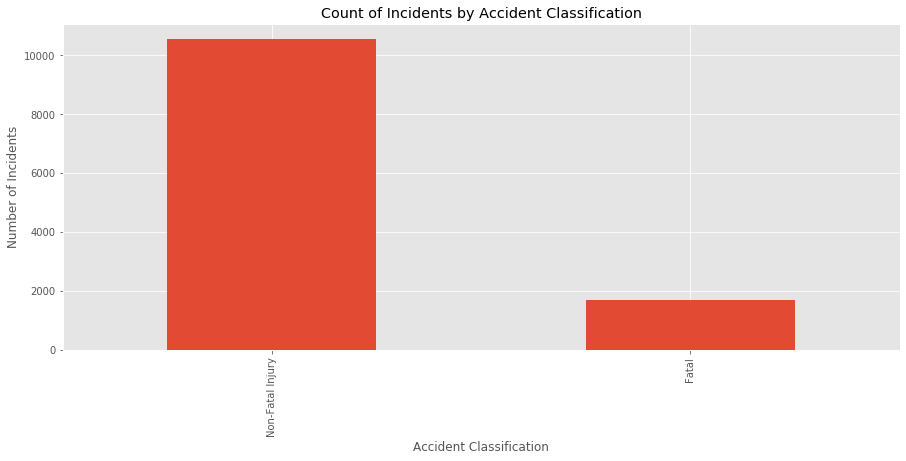

In [93]:
# Show the count of incidents by accident classification 
df_ksi['ACCLASS'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Accident Classification')
plt.ylabel('Number of Incidents')
plt.xlabel('Accident Classification')

plt.show()

While the Accident Classification is informative, it is not useful for our modeling.

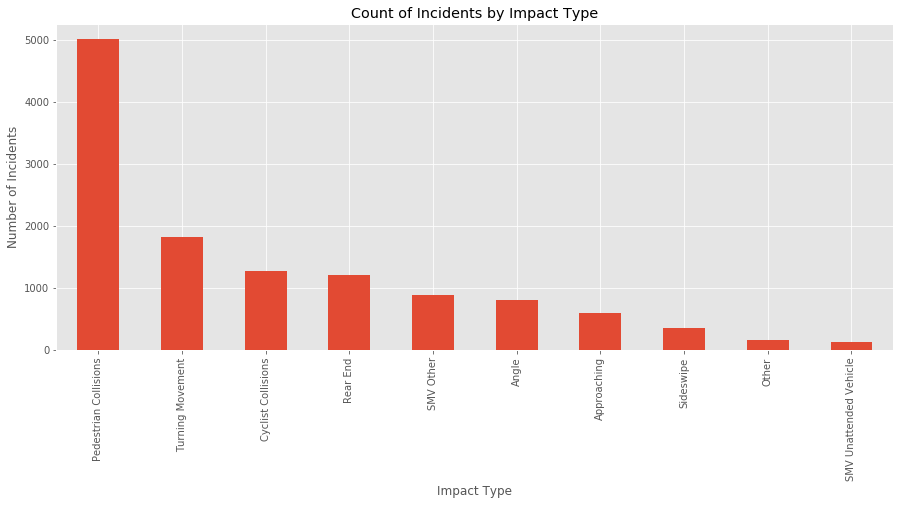

In [94]:
# Show the count of incidents by impact type 
df_ksi['IMPACTYPE'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Impact Type')
plt.ylabel('Number of Incidents')
plt.xlabel('Impact Type')

plt.show()

The Impact Type may also not be useful for this project.

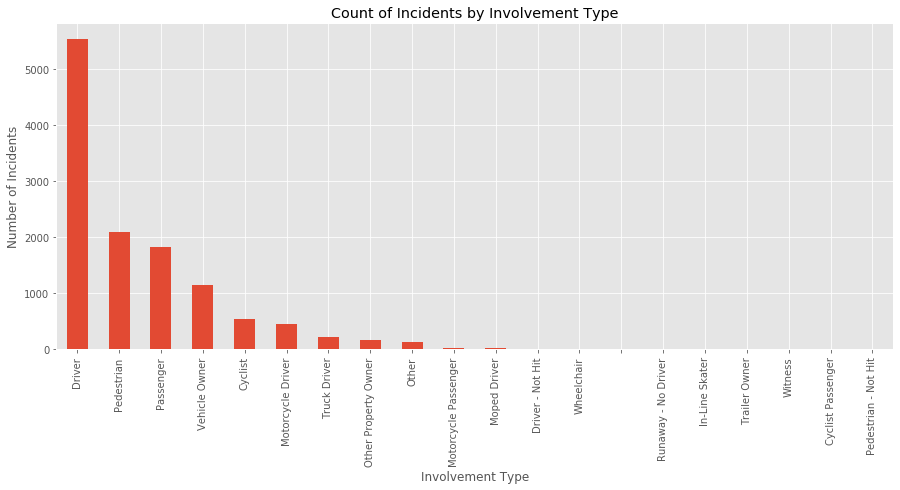

In [95]:
# Show the count of incidents by involvement type 
df_ksi['INVTYPE'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Involvement Type')
plt.ylabel('Number of Incidents')
plt.xlabel('Involvement Type')

plt.show()

The Involvement Type may also not be useful for this project.

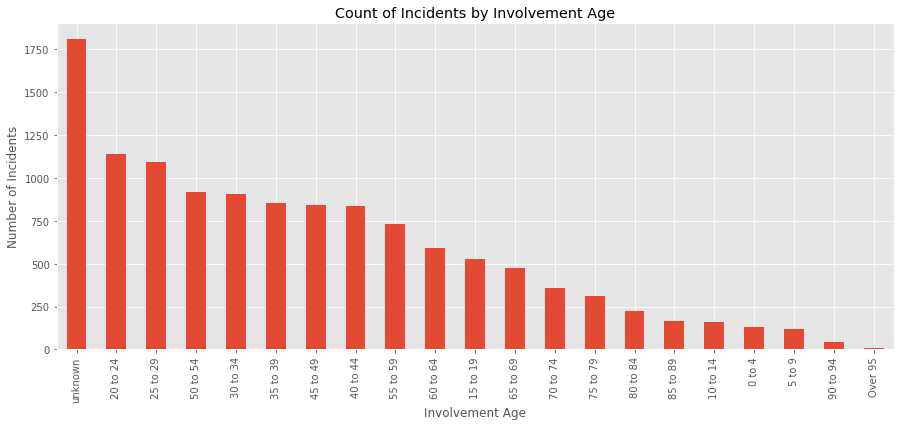

In [96]:
# Show the count of incidents by involvement age 
df_ksi['INVAGE'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Involvement Age')
plt.ylabel('Number of Incidents')
plt.xlabel('Involvement Age')

plt.show()

Involvment Age could be useful for modeling.  There may be a relationship between the traffic incidents and distractions by third-party signage.

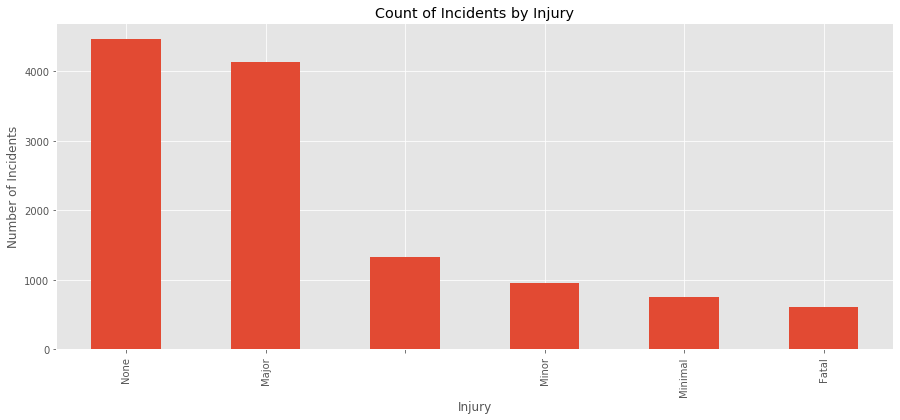

In [97]:
# Show the count of incidents by injury 
df_ksi['INJURY'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Injury')
plt.ylabel('Number of Incidents')
plt.xlabel('Injury')

plt.show()

Injury classification will not be useful in this project.

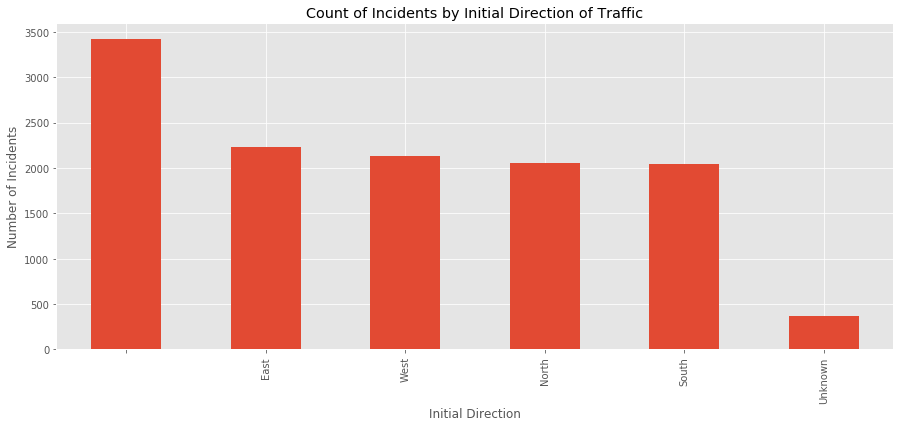

In [98]:
# Show the count of incidents by initial direction of traffic 
df_ksi['INITDIR'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Initial Direction of Traffic')
plt.ylabel('Number of Incidents')
plt.xlabel('Initial Direction')

plt.show()

The number of incidents where the Initial Direction of Traffic is known is fairly evenly split.  However, the proportion of unknown and blank fields may keep this field from being useful in the modeling.

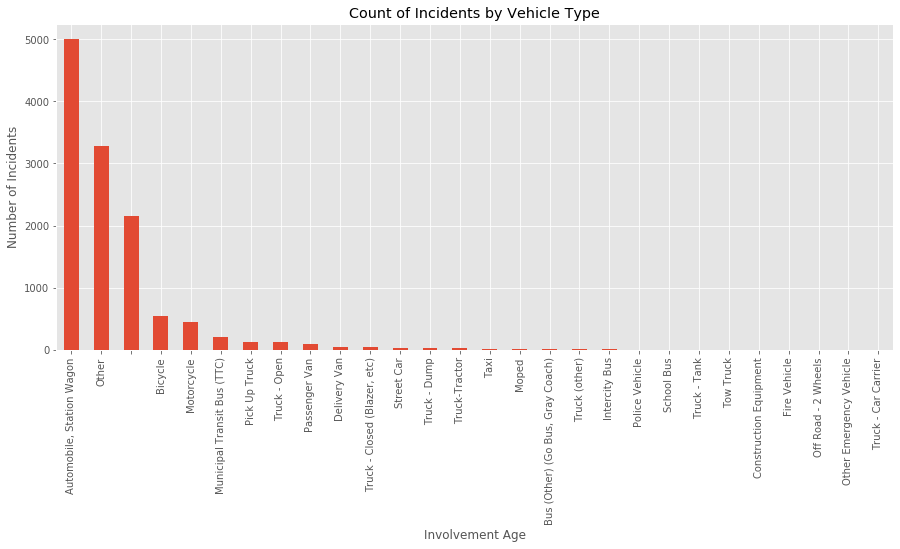

In [99]:
# Show the count of incidents by vehicle type 
df_ksi['VEHTYPE'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Vehicle Type')
plt.ylabel('Number of Incidents')
plt.xlabel('Involvement Age')

plt.show()

The Vehicle Type is likely less important than the driver of the vehicle in this project.  Consider excluding this field from the modeling.

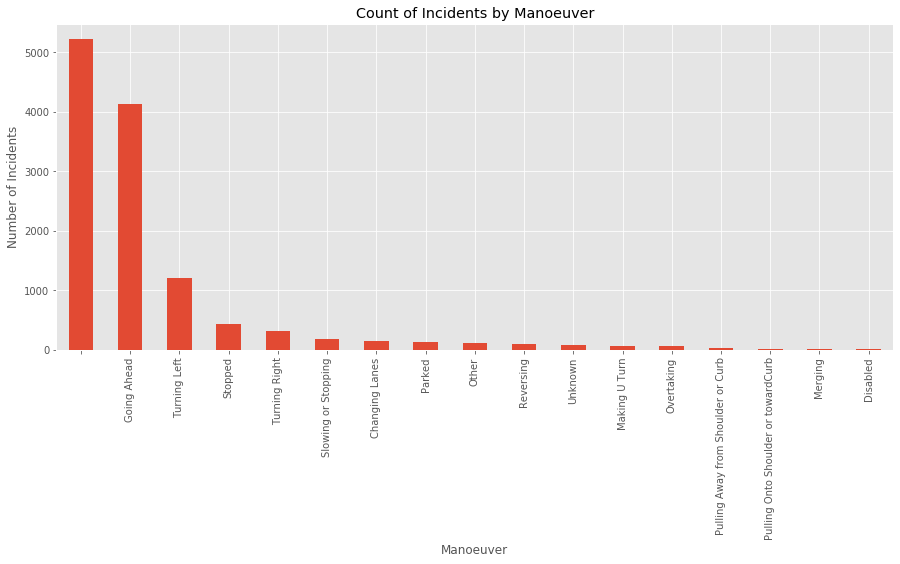

In [100]:
# Show the count of incidents by vehicle type 
df_ksi['MANOEUVER'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Manoeuver')
plt.ylabel('Number of Incidents')
plt.xlabel('Manoeuver')

plt.show()

The above is likely not useful for this project.

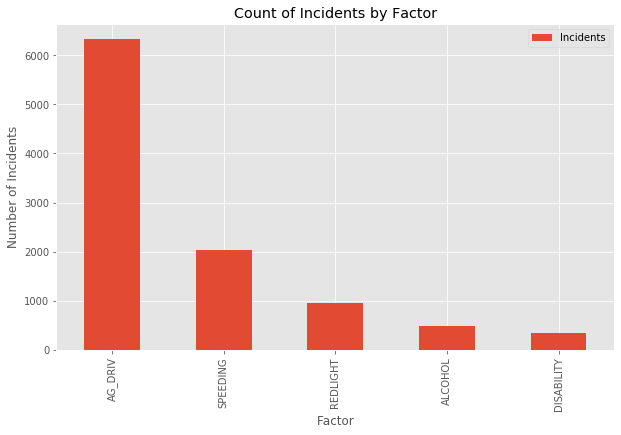

In [101]:
# Show the count of incidents by the determining factor
factor_list = ['SPEEDING','AG_DRIV','REDLIGHT','ALCOHOL','DISABILITY']
factor_df_list = []
for factor in factor_list:
    incidents = df_ksi[factor].value_counts()['Yes']
    fact_dict = {}
    #fact_dict[factor] = incidents
    fact_dict['Factor'] = factor
    fact_dict['Incidents'] = incidents
    factor_df_list.append(fact_dict)

df_factors = pd.DataFrame(factor_df_list)
df_factors.set_index('Factor', inplace=True)
df_factors.sort_values('Incidents', inplace=True, ascending=False)
    
#df_ksi['SPEEDING'].value_counts().plot(kind='bar', figsize=(15,6))
df_factors.plot(kind='bar', figsize=(10, 6))

plt.title('Count of Incidents by Factor')
plt.ylabel('Number of Incidents')
plt.xlabel('Factor')

plt.show()

These Factor fields will be useful in the analysis.  By focussing on the AG_DRIV (agressive/distracted driving), SPEEDING, and REDLIGHT fields, we may see a correlation of incidents occuring near third-party signs.

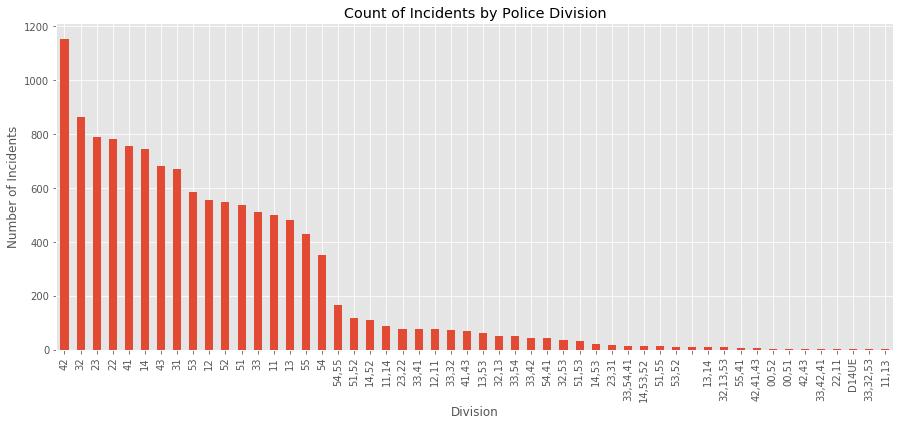

In [102]:
# Show the count of incidents by division
df_ksi['Division'].value_counts().plot(kind='bar', figsize=(15,6))

plt.title('Count of Incidents by Police Division')
plt.ylabel('Number of Incidents')
plt.xlabel('Division')

plt.show()

The top 3 count of incidents by Police Division are divisions containing highway 401 in the north end of the city.  Likely speed and distracted driving will be the greatest contributors to incidents in these areas as the volume of third-party signs along the 401 are minimal.  Consider excluding these areas from the modeling or focussing more on the main city arteries.